# Creating Training Dataset for DDR from preprocessed Gauges
#### Author: Tadd Bindas

This notebook is used to create the collection of training gauges, and reference csv file, used for DDR. Paths used are file locations on Wukong

In [2]:
import geopandas as gpd
import pandas as pd 
import numpy as np

The first step in creating this collection is to determine gauges that overlap with the High-Resolution Dataset. This will allow for benchmarking and transferability

In [3]:
import zarr
import os
dir_path = '/projects/mhpi/data/NWM/noaa-nwm-retrospective-3-0-pds/dHBV2.0_datasets'
MERIT_zone_forward_folder = 'dHBV2.0_MERIT_river_network_simulation/' ## Including 10-year (1990-1999) whole CONUS domain simulation on seamless river network. (40-year data will come with the publication of the paper)
streamflow_folder = "dHBV_streamflow_simulation_gages" ## Including 40-year (1980-2019) simulations on 7368 GAGES-II stations
flow_variable_folder = "MERIT_flux_states" ## Including 40-year (1980-2019) flow variables ['ET','Baseflow','Runoff','SoilMoisture','SWE'] on ~180,000 MERIT unit basins on CONUS
streamflow_zarr_root = zarr.open_group(os.path.join(dir_path, streamflow_folder) , mode='r')
streamflow_time = streamflow_zarr_root['time'][:]
gagesii_id_list = streamflow_zarr_root['GAGEID'][:]

observation = streamflow_zarr_root['observation'][:]
dHBVdMC_simulation = streamflow_zarr_root['dHBV2.0dMC_simulation'][:]   ## Streamflow simulation from dHBV2.0dMC
dHBVUH_simulation= streamflow_zarr_root['dHBV2.0UH_simulation'][:]    ## Streamflow simulation from dHBV2.0UH
print('dHBV2.0dMC_simulation unit is ', streamflow_zarr_root['dHBV2.0dMC_simulation'].attrs['units'])

dHBV2.0dMC_simulation unit is  ft3/s


Next, the filtered gauges csv is read from disk (this is created in Marquette here: https://github.com/taddyb/marquette/blob/master/notebooks/create_obs_csv.ipynb) as well as all meaningful necesary layers from the hydrofabric

In [4]:
gages_2000 = pd.read_csv("/projects/mhpi/data/MERIT/gage_information/formatted_gage_csvs/gages_3000_6km_merit_info_v7.csv")
gages_2000["STAID"] = gages_2000["STAID"].astype(str).str.zfill(8)

hydrofabric = {
    "divides": gpd.read_file("/projects/mhpi/data/hydrofabric/v2.2/conus_nextgen.gpkg", layer="divides"),
    "hydrolocations": gpd.read_file("/projects/mhpi/data/hydrofabric/v2.2/conus_nextgen.gpkg", layer="hydrolocations"),
}

We then find an intersection between the listed gauges, and hydrofabric basins to figure out which gauges are within the geospatial area of CONUS 

In [5]:
gages = streamflow_zarr_root["GAGEID"][:]
dhbv_gages_2000 = gages[np.where(np.isin(gages, gages_2000["STAID"].values))[0]]
gage_metadata_info = gpd.read_file("/projects/mhpi/data/hydrofabric/v2.2/gagesII_9322_sept30_2011.shp")
gage_metadata_info["STAID"] = gage_metadata_info["STAID"].astype(int)
gage_metadata_info = gage_metadata_info.set_index("STAID").sort_index()
gages_2000_gdf = gage_metadata_info.loc[np.array([int(_id) for _id in dhbv_gages_2000])]
gages_gdf = gages_2000_gdf.to_crs(hydrofabric["divides"].crs)
intersected_gages = gpd.sjoin(gages_gdf, hydrofabric["divides"], how="inner", predicate="within")
intersected_gages.head()

,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,...,divide_id,toid,type,ds_id,areasqkm,vpuid,id,lengthkm,tot_drainage_areasqkm,has_flowline
STAID,,,,,,,,,,,,,,,,,,,,,
1011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,None,yes,...,cat-5098,nex-5099,network,NaN,7.34040,01,wb-5098,2.809726,3184.258501,True
1013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,yes,yes,...,cat-5539,nex-5540,network,NaN,10.49850,01,wb-5539,6.449001,2247.957002,True
1015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,None,yes,...,cat-19684,nex-19685,network,NaN,4.60035,01,wb-19684,2.940224,2318.386498,True
1017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,None,yes,...,cat-19694,nex-19695,network,NaN,5.48325,01,wb-19694,3.702831,4289.139451,True
1019000,"Grand Lake Stream at Grand Lake Stream, Maine",Non-ref,NorthEast,620.6238,01,45.172522,-67.768800,ME,None,yes,...,cat-5939,nex-5940,network,NaN,4.25295,01,wb-5939,4.126052,580.084648,True


Then all IDs that are contained within the hydrolocations layer in the HF are filtered, and queried. Results are written to disk

In [13]:
gages_loc = hydrofabric["hydrolocations"][hydrofabric["hydrolocations"]["hl_reference"] == "gages"]
gages_loc = gages_loc.set_index("hl_uri")
gage_ids = [f"gages-{str(_id).zfill(8)}" for _id in intersected_gages.index]
gages_loc = gages_loc.loc[gages_loc.index.isin(gage_ids)]

In [15]:
gages_loc = gages_loc.reset_index()
gages_loc["STAID"] = [_id.split("-")[1] for _id in gages_loc.copy()["hl_uri"].values]
gages_loc

,index,hl_uri,poi_id,id,nex_id,hf_id,hl_link,hl_reference,hl_source,hl_x,hl_y,vpuid,STAID
0,0,gages-01096500,1676,wb-13946,nex-13947,503379.0,01096500,gages,ref-fab,1.968287e+06,2.439567e+06,01,01096500
1,1,gages-01030500,15303,wb-1937,nex-1938,122913.0,01030500,gages,ref-fab,2.133934e+06,2.813687e+06,01,01030500
2,2,gages-01031500,17384,wb-2467,nex-2468,143850.0,01031500,gages,ref-fab,2.069739e+06,2.757528e+06,01,01031500
3,3,gages-01170500,34678,wb-17792,nex-14470,628379.0,01170500,gages,ref-fab,1.893864e+06,2.404384e+06,01,01170500
4,4,gages-01199000,46221,wb-18448,nex-18056,815881.0,01199000,gages,ref-fab,1.846146e+06,2.324601e+06,01,01199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,1939,gages-11519500,34646,wb-3317007,nex-3317008,353771.0,11519500,gages,ref-fab,-2.204224e+06,2.386024e+06,18,11519500
1940,1940,gages-11345500,79514,wb-3305783,nex-3305749,395939.0,11345500,gages,ref-fab,-2.010897e+06,2.285290e+06,18,11345500
1941,1941,gages-11446500,76840,wb-3300796,nex-3300797,470038.0,11446500,gages,ref-fab,-2.151450e+06,2.021378e+06,18,11446500
1942,1942,gages-11335000,84142,wb-3311057,nex-3310982,1128579.0,11335000,gages,ref-fab,-2.138762e+06,2.002367e+06,18,11335000


In [16]:
gages_loc.to_csv("/projects/mhpi/tbindas/ddr/training_hydrolocations_2000.csv")

In summary, this notebook finds gauges that are used in previous MHPI experiments, then finds their locations in the hydrofabric, saving their output to disk as a csv for querying later

<Axes: >

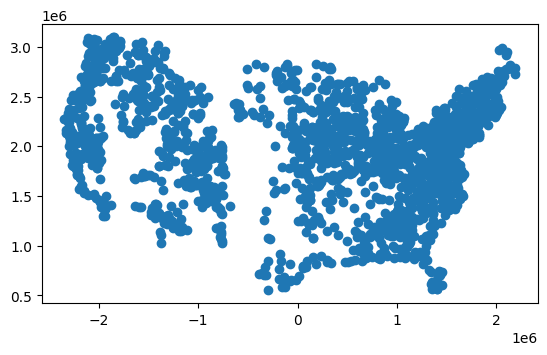

In [18]:
gage_metadata_info.loc[gage_metadata_info.index.isin(gages_loc["STAID"].astype(int))].plot()